# Extract Data from yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:

df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [3]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [4]:
close_df = df[['Date', 'Close']]

In [5]:
close_df.head()

,Date,Close
0,2019-01-02,20.674667
1,2019-01-03,20.024000
2,2019-01-04,21.179333
3,2019-01-07,22.330667
4,2019-01-08,22.356667


In [6]:
close_df_copy = close_df.copy()
close_df_copy = close_df_copy.drop('Date', axis = 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaler = scaler.fit(close_df_copy)
close_df_copy_scaled = scaler.transform(close_df_copy)

# Create a Window Function

In [8]:
X, y = [], []

window_size = 7
target = 1
for i in range(window_size, len(close_df_copy_scaled) - target + 1):
    X.append(close_df_copy_scaled[i - window_size: i, :])
    y.append(close_df_copy_scaled[i + target - 1:i + target, 0])
    
X, y = np.array(X), np.array(y)

In [9]:
print(X.shape, y.shape)

(1332, 7, 1) (1332, 1)


In [10]:
training_size=int(len(y)*0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1065, 7, 1) (267, 7, 1) (1065, 1) (267, 1)


In [12]:
def mse(preds, targets):
    return F.mse_loss(preds, targets)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape


In [13]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
 
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:

  n_timesteps, n_features, n_outputs = window_size, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='relu')(x)
  return tf.keras.Model(inputs, outputs)


In [ ]:
def train_transformer(epochs, learning_rate_lst):
    
    mae_lst = []
    RMSE_lst = []
    MAPE_lst = []
    r2_lst = []

    y_PRED_all = []
    
    for learning_rate in learning_rate_lst:

        model = build_transfromer(head_size=128, num_heads=8, ff_dim=2, 
                                  num_trans_blocks=4, mlp_units=[256], 
                                  mlp_dropout=0.10, dropout=0.2)
        
        checkpoint = ModelCheckpoint(f'tesla_model_transformer/model_tesla_window_7_{learning_rate}.h5', save_best_only=True)
        model.compile(loss='mean_squared_error',optimizer= Adam(learning_rate=learning_rate))
        model.fit(X_train, y_train, batch_size=32,epochs=epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

        model_load = load_model(f'tesla_model_transformer/model_tesla_window_7_{learning_rate}.h5')
        
        test_predictions = model_load.predict(X_test)
        test_predictions = scaler.inverse_transform(test_predictions)
        
        y_test1 = scaler.inverse_transform(y_test)
        
        y_TEST = y_test1
        y_PRED = test_predictions
        
        mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
        RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
        MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
        r2 = r2_score(y_TEST[-256:], y_PRED[-256:])

        mae_lst.append(mae)
        RMSE_lst.append(RMSE)
        MAPE_lst.append(MAPE)
        r2_lst.append(r2)
        
        print("Mean Absolute Error (MAE):", mae)
        print("RMSE",RMSE)
        print("MAPE", MAPE)
        print("R2", r2)
        y_PRED_all.append(y_PRED)
        
    return mae_lst, RMSE_lst, MAPE_lst, r2_lst, y_PRED_all, y_TEST


In [18]:
import optuna
def objective(trial):
    
    
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.002)
    num_heads = trial.suggest_categorical('n_heads', [8,16, 24])
    head_size = trial.suggest_categorical('head_size', [128, 256, 512])
    ff_dim = trial.suggest_categorical('ff_dim', [2, 4, 8])
    
    print('Learning Rate', learning_rate)
    print('num_heads', num_heads)
    print('head_size', head_size)
    print('head_size', ff_dim)
    
    model = build_transfromer(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, 
                              num_trans_blocks=4, mlp_units=[256], 
                              mlp_dropout=0.10, dropout=0.2)
    
    checkpoint = ModelCheckpoint(f'tesla_model_transformer/model_tesla_window_7_{learning_rate}.h5', save_best_only=True)
    model.compile(loss='mean_squared_error',optimizer= Adam(learning_rate=learning_rate))
    model.fit(X_train, y_train, batch_size=32,epochs=400, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

    model_load = load_model(f'tesla_model_transformer/model_tesla_window_7_{learning_rate}.h5')
    test_predictions = model_load.predict(X_test)
    test_predictions = scaler.inverse_transform(test_predictions)
        
    y_test1 = scaler.inverse_transform(y_test)
        
    y_TEST = y_test1
    y_PRED = test_predictions
        
    #mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
    #RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
    MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
    #r2 = r2_score(y_TEST[-256:], y_PRED[-256:])
    
    return MAPE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 20)

trial = study.best_trial
print(trial)

[I 2024-05-13 16:19:10,263] A new study created in memory with name: no-name-7ffec5fe-a990-4dc4-a9a8-36bae22eca3d


Learning Rate 0.0016442137183468237
num_heads 16
head_size 512
head_size 4
Epoch 1/400
34/34 [==============================] - 5s 47ms/step - loss: 0.0286 - val_loss: 0.0012
Epoch 2/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0022 - val_loss: 7.4000e-04
Epoch 3/400
34/34 [==============================] - 1s 34ms/step - loss: 0.0018 - val_loss: 6.7839e-04
Epoch 4/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 7.1805e-04
Epoch 5/400
34/34 [==============================] - 1s 34ms/step - loss: 0.0017 - val_loss: 5.3284e-04
Epoch 6/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0014 - val_loss: 5.5427e-04
Epoch 7/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0013 - val_loss: 5.6879e-04
Epoch 8/400
34/34 [==============================] - 1s 35ms/step - loss: 0.0014 - val_loss: 4.2349e-04
Epoch 9/400
34/34 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 3.96

[I 2024-05-13 16:26:18,262] Trial 0 finished with value: 2.310936455906693 and parameters: {'learning_rate': 0.0016442137183468237, 'n_heads': 16, 'head_size': 512, 'ff_dim': 4}. Best is trial 0 with value: 2.310936455906693.


Learning Rate 0.0009000412224124079
num_heads 24
head_size 512
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 58ms/step - loss: 0.0283 - val_loss: 0.0010
Epoch 2/400
34/34 [==============================] - 2s 45ms/step - loss: 0.0030 - val_loss: 7.9593e-04
Epoch 3/400
34/34 [==============================] - 1s 40ms/step - loss: 0.0024 - val_loss: 8.0878e-04
Epoch 4/400
34/34 [==============================] - 1s 40ms/step - loss: 0.0024 - val_loss: 8.2316e-04
Epoch 5/400
34/34 [==============================] - 1s 39ms/step - loss: 0.0019 - val_loss: 9.6185e-04
Epoch 6/400
34/34 [==============================] - 1s 44ms/step - loss: 0.0022 - val_loss: 6.0169e-04
Epoch 7/400
34/34 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 6.5301e-04
Epoch 8/400
34/34 [==============================] - 2s 45ms/step - loss: 0.0018 - val_loss: 5.5986e-04
Epoch 9/400
34/34 [==============================] - 1s 40ms/step - loss: 0.0015 - val_loss: 0.00

[I 2024-05-13 16:34:48,626] Trial 1 finished with value: 2.30976059356785 and parameters: {'learning_rate': 0.0009000412224124079, 'n_heads': 24, 'head_size': 512, 'ff_dim': 2}. Best is trial 1 with value: 2.30976059356785.


Learning Rate 0.001255724992033812
num_heads 24
head_size 128
head_size 8
Epoch 1/400
34/34 [==============================] - 5s 43ms/step - loss: 0.0298 - val_loss: 0.0041
Epoch 2/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0023 - val_loss: 8.8729e-04
Epoch 3/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0018 - val_loss: 6.2216e-04
Epoch 4/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0014 - val_loss: 5.3044e-04
Epoch 5/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0015 - val_loss: 5.7750e-04
Epoch 6/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0020 - val_loss: 9.5711e-04
Epoch 7/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0015 - val_loss: 4.8828e-04
Epoch 8/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0015 - val_loss: 4.2581e-04
Epoch 9/400
34/34 [==============================] - 1s 40ms/step - loss: 0.0013 - val_loss: 4.144

[I 2024-05-13 16:40:23,239] Trial 2 finished with value: 2.310143942452284 and parameters: {'learning_rate': 0.001255724992033812, 'n_heads': 24, 'head_size': 128, 'ff_dim': 8}. Best is trial 1 with value: 2.30976059356785.


Learning Rate 0.0013669575617711492
num_heads 8
head_size 512
head_size 8
Epoch 1/400
34/34 [==============================] - 5s 46ms/step - loss: 0.0220 - val_loss: 0.0069
Epoch 2/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0037 - val_loss: 9.0734e-04
Epoch 3/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 4/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 5/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0019 - val_loss: 6.9646e-04
Epoch 6/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 5.7265e-04
Epoch 8/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0016 - val_loss: 6.1772e-04
Epoch 9/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 6.6691e-04
Epoch 

[I 2024-05-13 16:46:12,316] Trial 3 finished with value: 2.3142446158712 and parameters: {'learning_rate': 0.0013669575617711492, 'n_heads': 8, 'head_size': 512, 'ff_dim': 8}. Best is trial 1 with value: 2.30976059356785.


Learning Rate 0.0010302778276198232
num_heads 24
head_size 512
head_size 4
Epoch 1/400
34/34 [==============================] - 5s 58ms/step - loss: 0.0293 - val_loss: 0.0021
Epoch 2/400
34/34 [==============================] - 1s 42ms/step - loss: 0.0031 - val_loss: 7.1512e-04
Epoch 3/400
34/34 [==============================] - 1s 37ms/step - loss: 0.0024 - val_loss: 7.8441e-04
Epoch 4/400
34/34 [==============================] - 1s 37ms/step - loss: 0.0021 - val_loss: 9.8844e-04
Epoch 5/400
34/34 [==============================] - 1s 37ms/step - loss: 0.0022 - val_loss: 8.1626e-04
Epoch 6/400
34/34 [==============================] - 1s 43ms/step - loss: 0.0022 - val_loss: 5.3161e-04
Epoch 7/400
34/34 [==============================] - 1s 38ms/step - loss: 0.0021 - val_loss: 6.1517e-04
Epoch 8/400
34/34 [==============================] - 1s 37ms/step - loss: 0.0018 - val_loss: 8.7412e-04
Epoch 9/400
34/34 [==============================] - 1s 37ms/step - loss: 0.0020 - val_loss: 6.61

[I 2024-05-13 16:55:00,739] Trial 4 finished with value: 2.309522196603468 and parameters: {'learning_rate': 0.0010302778276198232, 'n_heads': 24, 'head_size': 512, 'ff_dim': 4}. Best is trial 4 with value: 2.309522196603468.


Learning Rate 0.0019321282867187793
num_heads 24
head_size 512
head_size 8
Epoch 1/400
34/34 [==============================] - 6s 57ms/step - loss: 0.0455 - val_loss: 9.7374e-04
Epoch 2/400
34/34 [==============================] - 1s 42ms/step - loss: 0.0036 - val_loss: 8.4007e-04
Epoch 3/400
34/34 [==============================] - 1s 43ms/step - loss: 0.0027 - val_loss: 7.1138e-04
Epoch 4/400
34/34 [==============================] - 1s 38ms/step - loss: 0.0022 - val_loss: 7.9438e-04
Epoch 5/400
34/34 [==============================] - 1s 38ms/step - loss: 0.0020 - val_loss: 9.1889e-04
Epoch 6/400
34/34 [==============================] - 1s 43ms/step - loss: 0.0019 - val_loss: 6.2229e-04
Epoch 7/400
34/34 [==============================] - 1s 37ms/step - loss: 0.0018 - val_loss: 7.0087e-04
Epoch 8/400
34/34 [==============================] - 1s 42ms/step - loss: 0.0019 - val_loss: 5.2403e-04
Epoch 9/400
34/34 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 

[I 2024-05-13 17:03:44,326] Trial 5 finished with value: 2.355111363973642 and parameters: {'learning_rate': 0.0019321282867187793, 'n_heads': 24, 'head_size': 512, 'ff_dim': 8}. Best is trial 4 with value: 2.309522196603468.


Learning Rate 0.0014332163970285864
num_heads 8
head_size 512
head_size 4
Epoch 1/400
34/34 [==============================] - 5s 44ms/step - loss: 0.0291 - val_loss: 8.3844e-04
Epoch 2/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0027 - val_loss: 6.7603e-04
Epoch 3/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 4/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0020 - val_loss: 5.7608e-04
Epoch 5/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0018 - val_loss: 9.7800e-04
Epoch 6/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 5.0308e-04
Epoch 8/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0017 - val_loss: 4.4028e-04
Ep

[I 2024-05-13 17:09:33,600] Trial 6 finished with value: 2.298235068571179 and parameters: {'learning_rate': 0.0014332163970285864, 'n_heads': 8, 'head_size': 512, 'ff_dim': 4}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.001217273777000549
num_heads 8
head_size 128
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 45ms/step - loss: 0.0378 - val_loss: 0.0027
Epoch 2/400
34/34 [==============================] - 1s 42ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 3/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0023 - val_loss: 7.1703e-04
Epoch 5/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0021 - val_loss: 8.3330e-04
Epoch 6/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0019 - val_loss: 6.0737e-04
Epoch 7/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0016 - val_loss: 7.3429e-04
Epoch 8/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0017 - val_loss: 5.6234e-04
Epoch 9/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0017 - val_loss: 5.1610e-04
Epo

[I 2024-05-13 17:14:57,209] Trial 7 finished with value: 2.3009089211454636 and parameters: {'learning_rate': 0.001217273777000549, 'n_heads': 8, 'head_size': 128, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.00010390398107412645
num_heads 24
head_size 256
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 41ms/step - loss: 0.1371 - val_loss: 0.0064
Epoch 2/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0511 - val_loss: 0.0063
Epoch 3/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0303 - val_loss: 0.0061
Epoch 4/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0167 - val_loss: 0.0058
Epoch 5/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0089 - val_loss: 0.0024
Epoch 6/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 7/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 8.9641e-04
Epoch 8/400
34/34 [==============================] - 1s 34ms/step - loss: 0.0027 - val_loss: 7.2485e-04
Epoch 9/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 10/400
34/

[I 2024-05-13 17:21:22,214] Trial 8 finished with value: 2.3686643850868574 and parameters: {'learning_rate': 0.00010390398107412645, 'n_heads': 24, 'head_size': 256, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0009275646369046852
num_heads 8
head_size 512
head_size 8
Epoch 1/400
34/34 [==============================] - 5s 44ms/step - loss: 0.1136 - val_loss: 0.0060
Epoch 2/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 3/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0025 - val_loss: 7.7938e-04
Epoch 4/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0021 - val_loss: 9.9522e-04
Epoch 5/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0021 - val_loss: 7.0339e-04
Epoch 6/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0021 - val_loss: 7.5939e-04
Epoch 7/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0021 - val_loss: 7.1082e-04
Epoch 8/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 7.7477e-04
Epoch 9/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 6.0961e-0

[I 2024-05-13 17:27:07,896] Trial 9 finished with value: 2.3031392116906044 and parameters: {'learning_rate': 0.0009275646369046852, 'n_heads': 8, 'head_size': 512, 'ff_dim': 8}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0005707616421995065
num_heads 16
head_size 256
head_size 4
Epoch 1/400
34/34 [==============================] - 5s 44ms/step - loss: 0.0355 - val_loss: 0.0019
Epoch 2/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 3/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 4/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0026 - val_loss: 7.8601e-04
Epoch 5/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 6/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0027 - val_loss: 6.1988e-04
Epoch 7/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0022 - val_loss: 5.9053e-04
Epoch 9/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0021 - val_loss: 7.7735e-04
Epoch 10/

[I 2024-05-13 17:32:51,335] Trial 10 finished with value: 2.3191798102719585 and parameters: {'learning_rate': 0.0005707616421995065, 'n_heads': 16, 'head_size': 256, 'ff_dim': 4}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0015819690333576783
num_heads 8
head_size 128
head_size 2
Epoch 1/400
34/34 [==============================] - 4s 40ms/step - loss: 0.0196 - val_loss: 9.6523e-04
Epoch 2/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 3/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0024 - val_loss: 6.0304e-04
Epoch 4/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 6.5337e-04
Epoch 5/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0021 - val_loss: 5.8752e-04
Epoch 6/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0020 - val_loss: 5.6954e-04
Epoch 7/400
34/34 [==============================] - 1s 21ms/step - loss: 0.0018 - val_loss: 7.5712e-04
Epoch 8/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0018 - val_loss: 4.9674e-04
Epoch 9/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0016 - val_loss: 4.888

[I 2024-05-13 17:38:15,246] Trial 11 finished with value: 2.3124576281420604 and parameters: {'learning_rate': 0.0015819690333576783, 'n_heads': 8, 'head_size': 128, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0013758006702973872
num_heads 8
head_size 128
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 48ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 2/400
34/34 [==============================] - 1s 23ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 3/400
34/34 [==============================] - 1s 27ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 4/400
34/34 [==============================] - 1s 24ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 5/400
34/34 [==============================] - 1s 21ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 6/400
34/34 [==============================] - 1s 26ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 7/400
34/34 [==============================] - 1s 23ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 8/400
34/34 [==============================] - 1s 26ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 9/400
34/34 [==============================] - 1s 23ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 10/400
34/34 [======

[I 2024-05-13 17:43:35,840] Trial 12 finished with value: 94.40578661282503 and parameters: {'learning_rate': 0.0013758006702973872, 'n_heads': 8, 'head_size': 128, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0006474953855990168
num_heads 8
head_size 128
head_size 4
Epoch 1/400
34/34 [==============================] - 5s 47ms/step - loss: 0.0377 - val_loss: 0.0036
Epoch 2/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0028 - val_loss: 7.9588e-04
Epoch 3/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0023 - val_loss: 6.6692e-04
Epoch 4/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0021 - val_loss: 7.2158e-04
Epoch 5/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0022 - val_loss: 7.3183e-04
Epoch 6/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 7/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0024 - val_loss: 7.9925e-04
Epoch 8/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0018 - val_loss: 5.6211e-04
Epoch 9/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 5.5038e-0

[I 2024-05-13 17:48:58,823] Trial 13 finished with value: 2.3094223989317633 and parameters: {'learning_rate': 0.0006474953855990168, 'n_heads': 8, 'head_size': 128, 'ff_dim': 4}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0018595395443005303
num_heads 8
head_size 128
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 44ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 2/400
34/34 [==============================] - 1s 24ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 3/400
34/34 [==============================] - 1s 23ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 4/400
34/34 [==============================] - 1s 22ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 5/400
34/34 [==============================] - 1s 24ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 6/400
34/34 [==============================] - 1s 23ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 7/400
34/34 [==============================] - 1s 22ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 8/400
34/34 [==============================] - 1s 25ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 9/400
34/34 [==============================] - 1s 23ms/step - loss: 0.2210 - val_loss: 0.2784
Epoch 10/400
34/34 [======

[I 2024-05-13 17:54:23,217] Trial 14 finished with value: 2.3262739500250786 and parameters: {'learning_rate': 0.0018595395443005303, 'n_heads': 8, 'head_size': 128, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0012345027984903144
num_heads 8
head_size 256
head_size 4
Epoch 1/400
34/34 [==============================] - 5s 42ms/step - loss: 0.0745 - val_loss: 0.0030
Epoch 2/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0037 - val_loss: 8.2311e-04
Epoch 3/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0023 - val_loss: 6.6463e-04
Epoch 4/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0022 - val_loss: 5.9336e-04
Epoch 5/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0021 - val_loss: 5.8416e-04
Epoch 6/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0021 - val_loss: 5.9669e-04
Epoch 7/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0023 - val_loss: 5.5503e-04
Epoch 8/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0016 - val_loss: 5.2145e-04
Epoch 9/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 5.339

[I 2024-05-13 17:59:59,071] Trial 15 finished with value: 2.307064929367214 and parameters: {'learning_rate': 0.0012345027984903144, 'n_heads': 8, 'head_size': 256, 'ff_dim': 4}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0016005142518995077
num_heads 8
head_size 128
head_size 4
Epoch 1/400
34/34 [==============================] - 4s 38ms/step - loss: 0.0807 - val_loss: 0.0011
Epoch 2/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0034 - val_loss: 9.0727e-04
Epoch 3/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 4/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 7.4987e-04
Epoch 5/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0020 - val_loss: 6.4917e-04
Epoch 6/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0018 - val_loss: 5.6874e-04
Epoch 7/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0015 - val_loss: 4.7398e-04
Epoch 9/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0015 - val_loss: 5.1540e-04
Ep

[I 2024-05-13 18:05:13,433] Trial 16 finished with value: 2.3121111057957116 and parameters: {'learning_rate': 0.0016005142518995077, 'n_heads': 8, 'head_size': 128, 'ff_dim': 4}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0006308843075068186
num_heads 16
head_size 512
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 45ms/step - loss: 0.0404 - val_loss: 0.0021
Epoch 2/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0041 - val_loss: 8.1872e-04
Epoch 3/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0027 - val_loss: 9.8091e-04
Epoch 4/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 6.7386e-04
Epoch 5/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0027 - val_loss: 6.4101e-04
Epoch 6/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0026 - val_loss: 9.0975e-04
Epoch 7/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 5.4043e-04
Epoch 8/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 5.0840e-04
Epoch 9/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 4.79

[I 2024-05-13 18:11:31,118] Trial 17 finished with value: 2.3024555804074947 and parameters: {'learning_rate': 0.0006308843075068186, 'n_heads': 16, 'head_size': 512, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0011267149410321515
num_heads 8
head_size 128
head_size 4
Epoch 1/400
34/34 [==============================] - 4s 38ms/step - loss: 0.0089 - val_loss: 9.2839e-04
Epoch 2/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0022 - val_loss: 7.8130e-04
Epoch 3/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0017 - val_loss: 6.9055e-04
Epoch 4/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/400
34/34 [==============================] - 1s 20ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0014 - val_loss: 4.6636e-04
Epoch 7/400
34/34 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 6.2867e-04
Epoch 8/400
34/34 [==============================] - 1s 25ms/step - loss: 0.0013 - val_loss: 4.2970e-04
Epoch 9/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0014 - val_loss: 4.8617e-0

[I 2024-05-13 18:16:28,143] Trial 18 finished with value: 2.313569148239381 and parameters: {'learning_rate': 0.0011267149410321515, 'n_heads': 8, 'head_size': 128, 'ff_dim': 4}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0014793579110505932
num_heads 8
head_size 256
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 42ms/step - loss: 0.0301 - val_loss: 0.0012
Epoch 2/400
34/34 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 3/400
34/34 [==============================] - 1s 24ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0026 - val_loss: 8.7101e-04
Epoch 5/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0023 - val_loss: 7.1577e-04
Epoch 6/400
34/34 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 8.7535e-04
Epoch 7/400
34/34 [==============================] - 1s 30ms/step - loss: 0.0018 - val_loss: 6.9601e-04
Epoch 8/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0015 - val_loss: 5.5239e-04
Epoch 9/400
34/34 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 8.2312e-04
Ep

[I 2024-05-13 18:21:36,341] Trial 19 finished with value: 2.3058871137029664 and parameters: {'learning_rate': 0.0014793579110505932, 'n_heads': 8, 'head_size': 256, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0018195231608118924
num_heads 16
head_size 512
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 45ms/step - loss: 0.0413 - val_loss: 0.0074
Epoch 2/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0033 - val_loss: 8.5052e-04
Epoch 3/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0025 - val_loss: 8.3976e-04
Epoch 4/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0023 - val_loss: 9.3740e-04
Epoch 5/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 6.5010e-04
Epoch 6/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 6.5188e-04
Epoch 7/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0016 - val_loss: 5.2675e-04
Epoch 8/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0015 - val_loss: 5.9282e-04
Epoch 9/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0018 - val_loss: 5.06

[I 2024-05-13 18:27:55,217] Trial 20 finished with value: 2.317594228543839 and parameters: {'learning_rate': 0.0018195231608118924, 'n_heads': 16, 'head_size': 512, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0006474976730799785
num_heads 16
head_size 512
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 49ms/step - loss: 0.0395 - val_loss: 0.0034
Epoch 2/400
34/34 [==============================] - 1s 31ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 3/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0024 - val_loss: 7.8880e-04
Epoch 4/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0022 - val_loss: 8.0049e-04
Epoch 5/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 7.7158e-04
Epoch 6/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0019 - val_loss: 7.9628e-04
Epoch 7/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0024 - val_loss: 7.9479e-04
Epoch 8/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0021 - val_loss: 7.7259e-04
Epoch 9/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0017 - val_loss: 6.6764e-

[I 2024-05-13 18:34:23,778] Trial 21 finished with value: 2.301895775907802 and parameters: {'learning_rate': 0.0006474976730799785, 'n_heads': 16, 'head_size': 512, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.00022202951114877446
num_heads 16
head_size 512
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 49ms/step - loss: 0.1703 - val_loss: 0.0051
Epoch 2/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0291 - val_loss: 0.0100
Epoch 3/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 4/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0031 - val_loss: 6.8947e-04
Epoch 5/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0028 - val_loss: 8.8402e-04
Epoch 6/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0025 - val_loss: 5.9790e-04
Epoch 7/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/400
34/34 [==============================] - 1s 29ms/step - loss: 0.0026 - val_loss: 7.7045e-04
Epoch 9/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 5.9754e-04
Epoc

[I 2024-05-13 18:40:52,702] Trial 22 finished with value: 2.325310258738335 and parameters: {'learning_rate': 0.00022202951114877446, 'n_heads': 16, 'head_size': 512, 'ff_dim': 2}. Best is trial 6 with value: 2.298235068571179.


Learning Rate 0.0004164109283424592
num_heads 16
head_size 512
head_size 2
Epoch 1/400
34/34 [==============================] - 5s 48ms/step - loss: 0.0401 - val_loss: 0.0066
Epoch 2/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 3/400
34/34 [==============================] - 1s 32ms/step - loss: 0.0027 - val_loss: 8.4089e-04
Epoch 4/400
34/34 [==============================] - 1s 33ms/step - loss: 0.0028 - val_loss: 8.2376e-04
Epoch 5/400
34/34 [==============================] - 1s 27ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/400
34/34 [==============================] - 1s 34ms/step - loss: 0.0025 - val_loss: 6.7000e-04
Epoch 7/400
34/34 [==============================] - 1s 26ms/step - loss: 0.0023 - val_loss: 7.4714e-04
Epoch 8/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0024 - val_loss: 7.2903e-04
Epoch 9/400
34/34 [==============================] - 1s 28ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch

[W 2024-05-13 18:44:26,940] Trial 23 failed with parameters: {'learning_rate': 0.0004164109283424592, 'n_heads': 16, 'head_size': 512, 'ff_dim': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\gpu\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12616\3363984316.py", line 21, in objective
    model.fit(X_train, y_train, batch_size=32,epochs=400, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])
  File "C:\Users\User\anaconda3\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\User\anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\User\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\util\traceback_utils.p

KeyboardInterrupt: 

In [19]:
# {'learning_rate': 0.0014332163970285864, 'n_heads': 8, 'head_size': 512, 'ff_dim': 4}
model_load = load_model(f'tesla_model_transformer/model_tesla_window_7_0.0014332163970285864.h5') 

In [22]:
test_predictions = model_load.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
    
y_test1 = scaler.inverse_transform(y_test)
    
y_TEST = y_test1
y_PRED = test_predictions
    
mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
r2 = r2_score(y_TEST[-256:], y_PRED[-256:])

print("Mean Absolute Error (MAE):", mae)
print("RMSE",RMSE)
print("MAPE", MAPE)
print("R2", r2)

9/9 [==============================] - 0s 42ms/step
Mean Absolute Error (MAE): 4.98997402191162
RMSE 6.767348225899824
MAPE [2.29823507]
R2 0.9676527320247853


In [ ]:
# metrics_df = pd.DataFrame({
#     'Learning Rate': learning_rate_lst,
#     'MAE': [mae_lst[0], mae_lst[1], mae_lst[2]],
#     'RMSE': [RMSE_lst[0], RMSE_lst[1], RMSE_lst[2]],
#     'MAPE': [MAPE_lst[0], MAPE_lst[1], MAPE_lst[2]]
# })
# metrics_df

In [39]:
y_PRED_all_ = [i[0] for i in y_PRED]

In [40]:
y_TEST_ = [i[0] for i in y_TEST]

In [41]:
test_results = pd.DataFrame(data={'Predicted':y_PRED_all_, 'Actuals':y_TEST_, 'Date': close_df['Date'].iloc[-267:]})

In [42]:
test_results

,Predicted,Actuals,Date
1072,193.459000,185.520004,2023-04-05
1073,186.731079,185.059998,2023-04-06
1074,184.481644,184.509995,2023-04-10
1075,184.455215,186.789993,2023-04-11
1076,186.760040,180.539993,2023-04-12
...,...,...,...
1334,147.550385,142.050003,2024-04-22
1335,142.805420,144.679993,2024-04-23
1336,143.645737,162.130005,2024-04-24
1337,162.623398,170.179993,2024-04-25


In [43]:
test_results = test_results.set_index('Date')

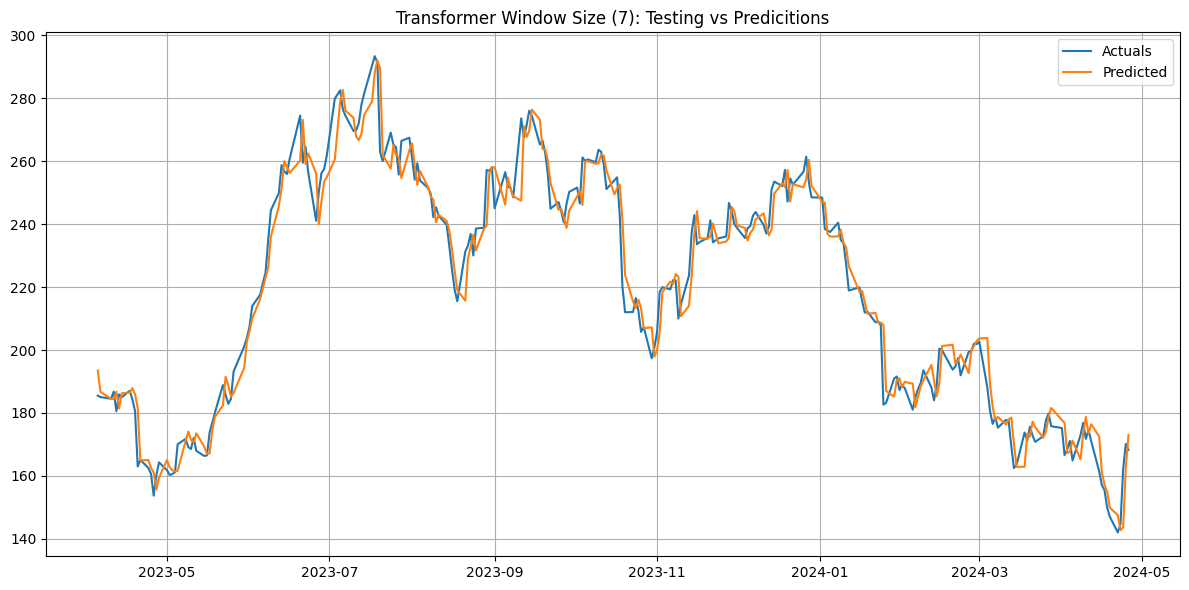

In [44]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('Transformer Window Size (7): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

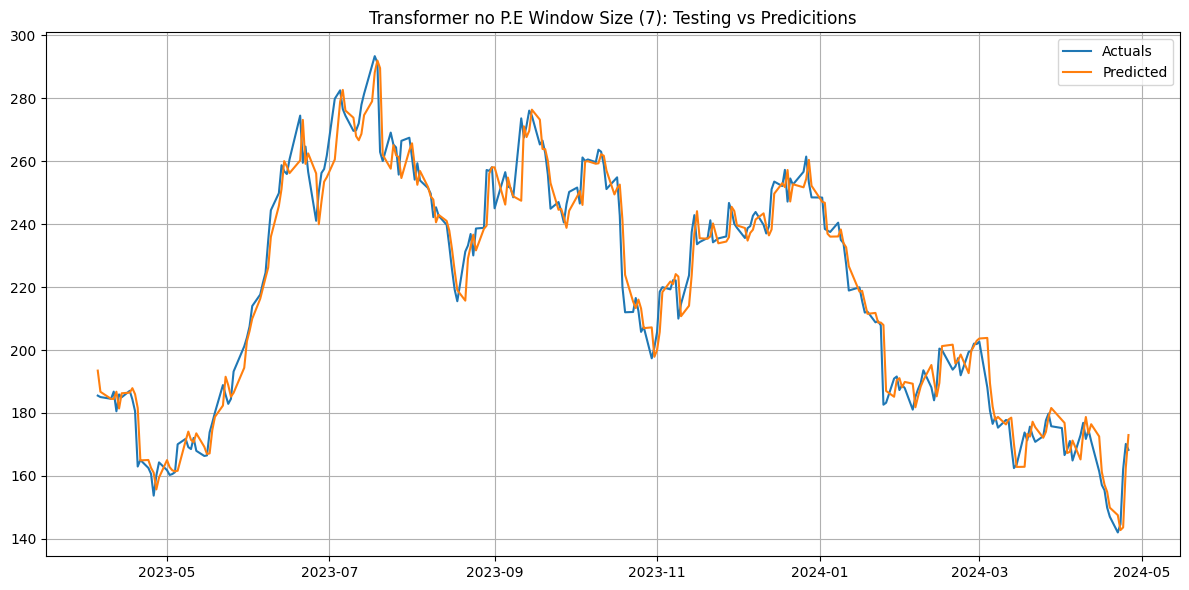

In [45]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('Transformer no P.E Window Size (7): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()